In [2]:
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [3]:
# leer datos
df = pd.read_csv('./../creditRisk_creditCardFraud/data_fraude.csv')

In [4]:
# pre-process datos (si es necesario)
df = df.rename(columns={'0.1':'Class'}).\
drop('Unnamed: 0',axis=1)

yvar = df.Class
xvars = df[[x for x in df.columns if x != 'Class']]

In [5]:
# dividir train / test para variables independientes (x)  y dependiente (y)
xtrain, xtest, ytrain, ytest = train_test_split(xvars, yvar, train_size = 0.80, random_state = 2)

In [6]:
# crear matrices de xgboost

trainXGB = xgboost.DMatrix(data=xtrain,
                           label=ytrain)

testXGB = xgboost.DMatrix(data=xtest,
                          label=ytest)

In [21]:
def findXGB(trainXGB,
           testXGB,
           iters):
    
    # iniciar el valor de la metrica del cual partimos (alto para metricas que queremos reducir
    # y viceversa
    
    best_metric = 0
    best_params = {}
    
    # muestrear numeros de forma aleatoria (dentro de un rango) para los hyperparámetros 
    # cada iteracion 
    
    for iteration in range(iters):

        params = {
                'tree_method' : 'exact',
                'booster' : 'gbtree', # 'gblinear'
                'eta' : random.uniform(0.01, 0.3),
                'max_depth' : random.randint(5,14),
                'reg_lambda' : random.uniform(0.01, 0.4),
                'reg_alpha' : random.uniform(0.01, 0.4),
                'gamma' : random.randint(0, 20),
                'subsample' : random.uniform(0.5, 1),
                'colsample_bytree' : random.uniform(0.5, 1),
                'objective' : 'binary:logistic',
                'eval_metric' : 'auc'
            }
    
    # ajustar un modelo utilizando validacion cruzada para probar los hiperparámetros en
    # todas las regiones de los datos de entrenamiento
    
        xgb_cv = xgboost.cv(
            params = params, 
            dtrain = trainXGB, 
               nfold=10,
               metrics={'auc'}, 
               seed=0,
               callbacks=[xgboost.callback.EvaluationMonitor(show_stdv=True),
                          xgboost.callback.EarlyStopping(2)])
 
    # registrar la metrica
    
        auc = xgb_cv.iloc[-1,2]
    
    # si la metrica alcanzada fuera mejor que la actual, reemplazar la actual  y guardar los
    # hiperparámetros del modelo que llegó a ella.
    # Nota : la metrica debe ser menor si se esta reduciendo (ej rmse) o mayor si se esta aumentando (ej auc)
    
        if auc > best_metric:

            best_metric = auc
            best_params = params
    
    # Ajustar un modelo final con los mejores hiperparámetros, probándolo ahora en el test set
    
    final_model = xgboost.XGBClassifier( 
        eval_metric='auc',
        early_stopping_rounds=2,
        n_estimators=1000000)

    final_model.set_params(**best_params)

    final_model.fit(
        X=xtrain,
        y=ytrain,
        eval_set = [(xtrain, ytrain),(xtest, ytest)]
    )
    
    return final_model

In [ ]:
# correr la funcion
finalXGB = findXGB(trainXGB, testXGB, iters=10)

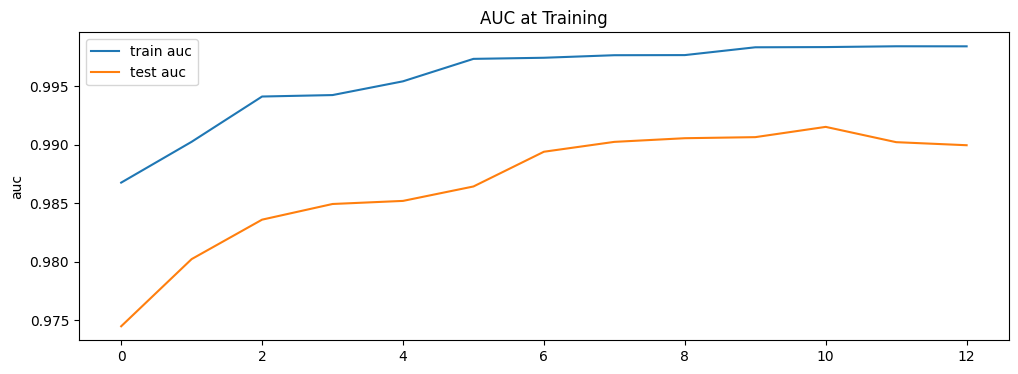

In [35]:
# visualize metrics 

results = finalXGB.evals_result_
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(range(len(results['validation_0']['auc'])), results['validation_0']['auc'], label='train auc')
ax.plot(range(len(results['validation_1']['auc'])), results['validation_1']['auc'], label='test auc')
ax.legend()
plt.ylabel("auc")
plt.title('AUC at Training')
plt.show()